<a href="https://colab.research.google.com/github/NGeorggin/COMPSCI175FinalProject/blob/main/CS175DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rlcard
import os
import argparse
import rlcard
from rlcard.agents import (
    CFRAgent,
    RandomAgent,
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)

In [51]:
import os
import argparse
import csv

import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

def train(args):

    # Check whether gpu is available
    device = get_device()

    # Seed numpy, torch, random
    set_seed(args.seed)

    # Make the environment with seed
    env = rlcard.make(
        args.env,
        config={
            'seed': args.seed,
        }
    )

    # Initialize the agent and use random agents as opponents
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,128],
        device=device,
        batch_size=64
    )

    games_won = 0
    csv_path2 = 'experiments/no_limit_holdem_dqn_result/result.csv'
    with open(csv_path2, 'a') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['episode', 'reward'])

    agents = [agent]
    for _ in range(1, env.num_players):
        agents.append(RandomAgent(num_actions=env.num_actions))
    env.set_agents(agents)

    #agent = torch.load(args.save_path)

    # Start training
    with Logger(args.log_dir) as logger:
        for episode in range(args.num_episodes):

            # Generate data from the environment
            trajectories, payoffs = env.run(is_training=True)

            # Reorganaize the data to be state, action, reward, next_state, done
            trajectories = reorganize(trajectories, payoffs)
            if payoffs[0] > 0:
                games_won += 1

            # Feed transitions into agent memory, and train the agent
            # Here, we assume that DQN always plays the first position
            # and the other players play randomly (if any)
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance. Play with random agents.
            if episode % args.evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        args.num_eval_games,
                    )[0]
                )
                with open(csv_path2, 'a') as f:
                    csv_writer = csv.writer(f)
                    if episode == 0:
                        win_rate = 0
                    else:
                        win_rate = games_won / episode
                    csv_writer.writerow([episode, win_rate])

        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
        fig_path2 = 'experiments/no_limit_holdem_dqn_result/fig2.png'

    # Plot the learning curve
    plot_curve(csv_path, fig_path, args.algorithm)
    plot_curve(csv_path2, fig_path2, 'win_rate')

    # Save model
    save_path = os.path.join(args.log_dir, 'model.pth')
    torch.save(agent, save_path)
    #agent.save_checkpoint('/content/experiments/no_limit_holdem_dqn_result/')
    print('Model saved in', save_path)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  -4.1205
----------------------------------------
INFO - Step 100, rl-loss: 1328.360595703125
INFO - Copied model parameters to target network.
INFO - Step 175, rl-loss: 1636.125
----------------------------------------
  episode      |  100
  reward       |  0.502
----------------------------------------
INFO - Step 339, rl-loss: 1733.9814453125
----------------------------------------
  episode      |  200
  reward       |  0.9475
----------------------------------------
INFO - Step 505, rl-loss: 1406.809814453125
----------------------------------------
  episode      |  300
  reward       |  1.4235
----------------------------------------
INFO - Step 667, rl-loss: 1228.8385009765625
----------------------------------------
  episode      |  400
  reward       |  1.8745
----------------------------------------
INFO - Step 834, rl-loss: 1102.186767578125
-----------------------------

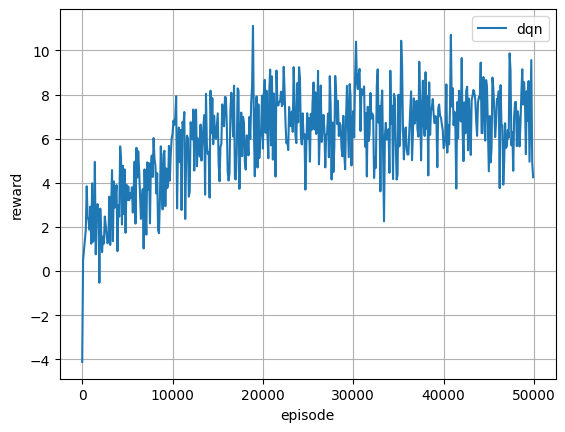

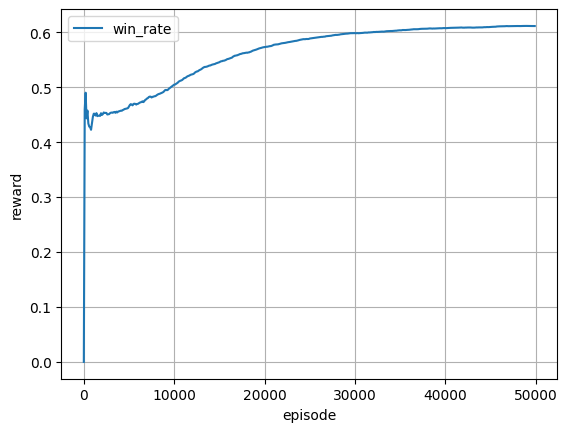

In [53]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser("DQN example in RLCard")
    parser.add_argument(
        '--env',
        type=str,
        default='no-limit-holdem',
        choices=[
            'no-limit-holdem',
        ],
    )
    parser.add_argument(
        '--algorithm',
        type=str,
        default='dqn',
        choices=[
            'dqn',
        ],
    )
    parser.add_argument(
        '--cuda',
        type=str,
        default='',
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=42,
    )
    parser.add_argument(
        '--num_episodes',
        type=int,
        default=50000,
    )
    parser.add_argument(
        '--num_eval_games',
        type=int,
        default=2000,
    )
    parser.add_argument(
        '--evaluate_every',
        type=int,
        default=100,
    )
    parser.add_argument(
        '--log_dir',
        type=str,
        default='experiments/no_limit_holdem_dqn_result/',
    )
    parser.add_argument(
        '--save_path',
        type=str,
        default=os.path.join('experiments/no_limit_holdem_dqn_result/', 'model.pth'),
    )

    args, unknown = parser.parse_known_args()

    os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda
    train(args)